In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.api import qqplot

In [2]:
# read data
df = pd.read_csv('Clean_Dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
df.shape
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


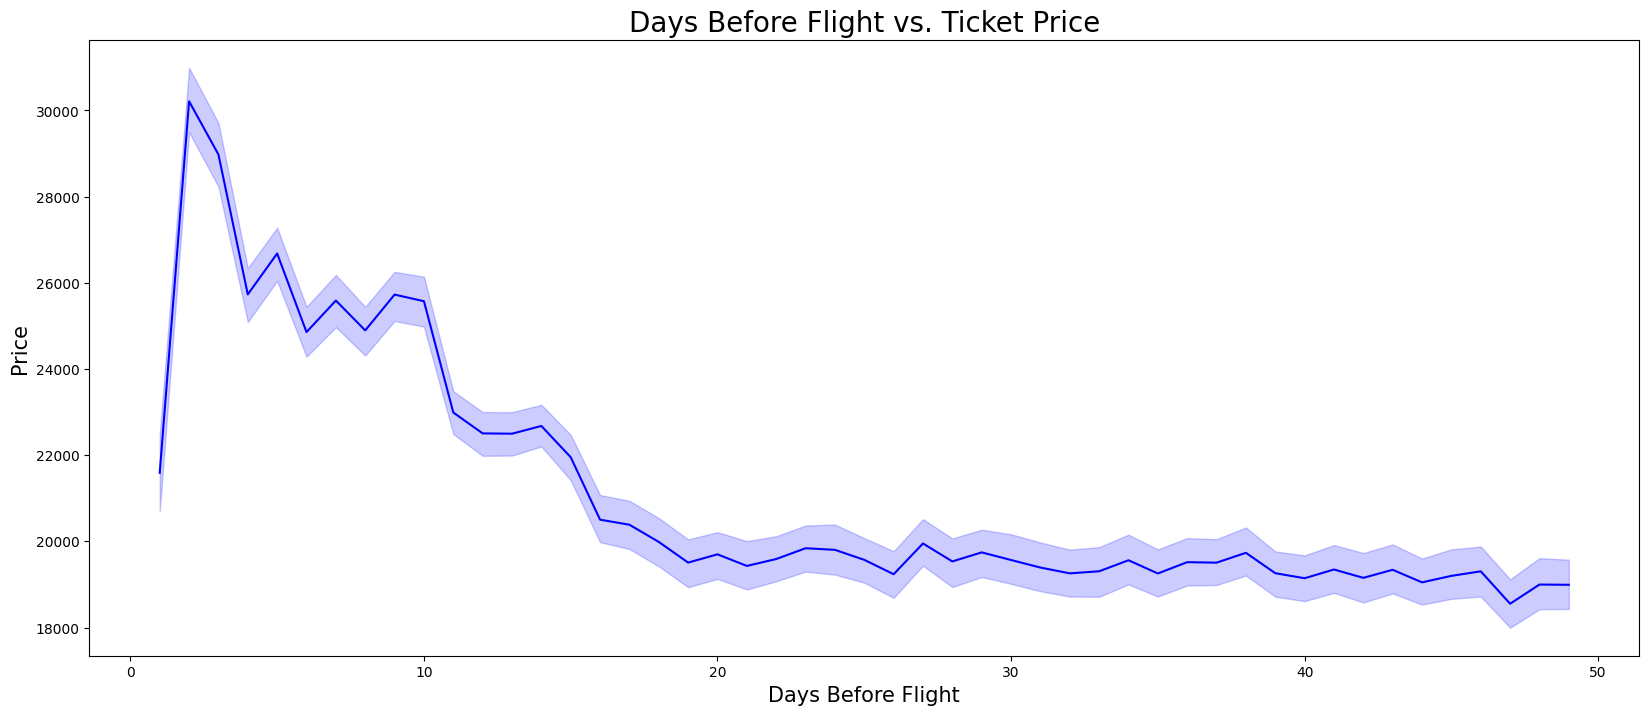

In [3]:
# plot data: all airlines
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='days_left', y='price', color='blue')
plt.title('Days Before Flight vs. Ticket Price', fontsize=20)
plt.xlabel('Days Before Flight', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

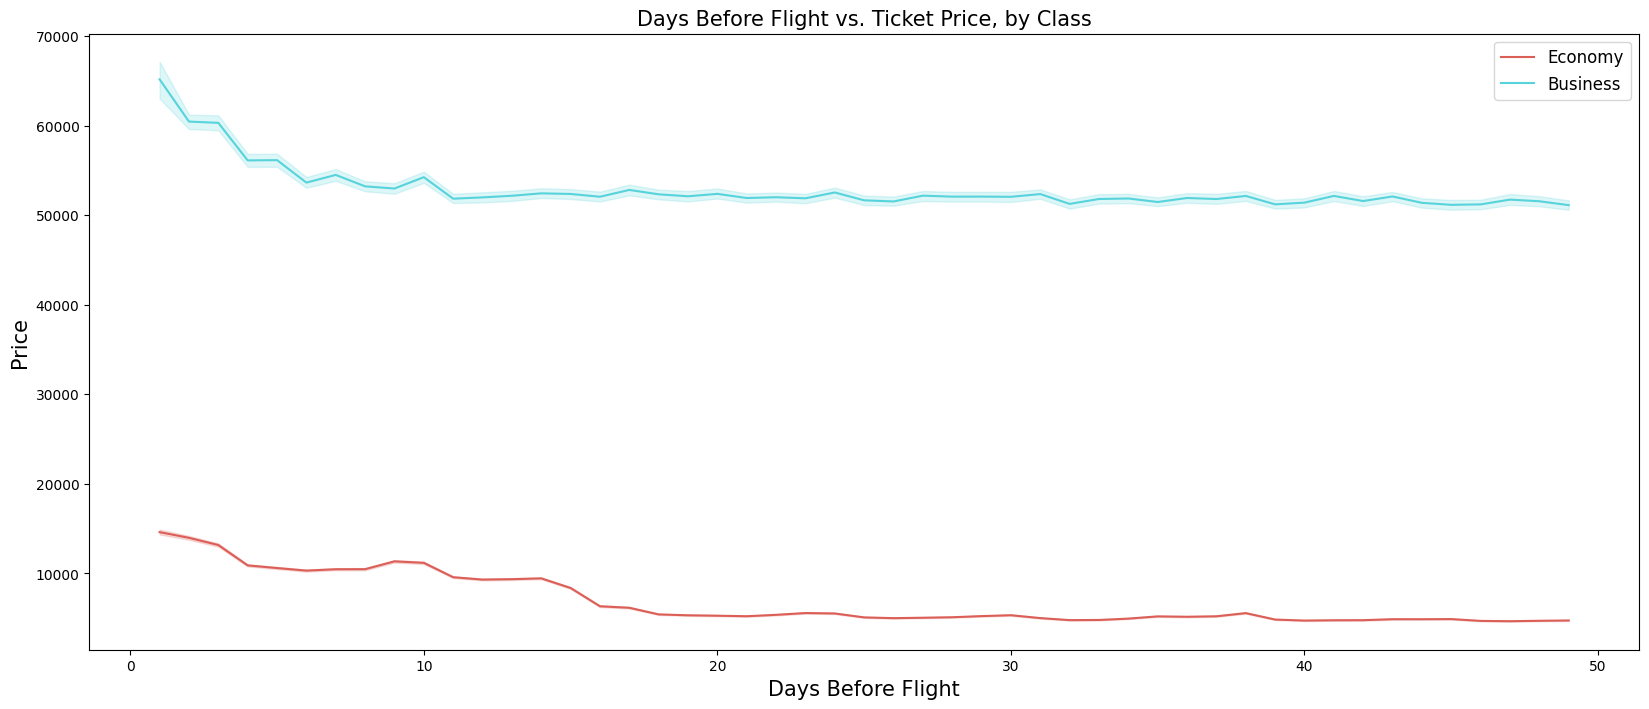

In [4]:
# plot data: each airline
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='days_left', y='price', color='blue', hue='class', palette='hls')
plt.title('Days Before Flight vs. Ticket Price, by Class', fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Days Before Flight', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

In [4]:
# separate data by airline
df_spicejet = df[df['airline'] == 'SpiceJet']
df_asia = df[df['airline'] == 'AirAsia']
df_vistara = df[df['airline'] == 'Vistara'] # has business class
df_gofirst = df[df['airline'] == 'GO_FIRST']
df_indigo = df[df['airline'] == 'Indigo']
df_india = df[df['airline'] == 'Air_India'] # has business class

In [7]:
# update this when running each airline
this_df = df_spicejet

# use average prices
df_avg = this_df.groupby('days_left', as_index=False)['price'].mean()
df_avg.head()

,days_left,price
0,1,13136.913043
1,2,11362.181818
2,3,9745.265432
3,4,7961.189055
4,5,7656.860465


In [8]:
#### Method 1: Simple Moving Average ####

# N = 3
df_avg['SMA_3'] = df_avg.price.rolling(3, min_periods=1).mean()

# N = 5
df_avg['SMA_5'] = df_avg.price.rolling(5, min_periods=1).mean()

# N = 7
df_avg['SMA_7'] = df_avg.price.rolling(7, min_periods=1).mean()

# N = 10
df_avg['SMA_10'] = df_avg.price.rolling(10, min_periods=1).mean()

df_avg.head()


,days_left,price,SMA_3,SMA_5,SMA_7,SMA_10
0,1,13136.913043,13136.913043,13136.913043,13136.913043,13136.913043
1,2,11362.181818,12249.547431,12249.547431,12249.547431,12249.547431
2,3,9745.265432,11414.786765,11414.786765,11414.786765,11414.786765
3,4,7961.189055,9689.545435,10551.387337,10551.387337,10551.387337
4,5,7656.860465,8454.438317,9972.481963,9972.481963,9972.481963


In [17]:
# forecast up to 100 days left

# update for different window sizes
this_SMA = 'SMA_3'

# for 50-100 days left, use prediction value
for i in range(49,101):
    df_avg.loc[i] = df_avg[this_SMA][i-1]



5374.034762283413

In [ ]:
# all SMA plot
colors = ['gray', 'red', 'green', 'blue', 'purple']
df_avg.plot(color=colors, linewidth=3, figsize=(20,8))
plt.legend(labels=['Average Price', '3-Day SMA', '5-Day SMA', '7-Day SMA', '10-Day SMA'], fontsize=12)
plt.title('Average Prices per Days Left Before Flight')
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

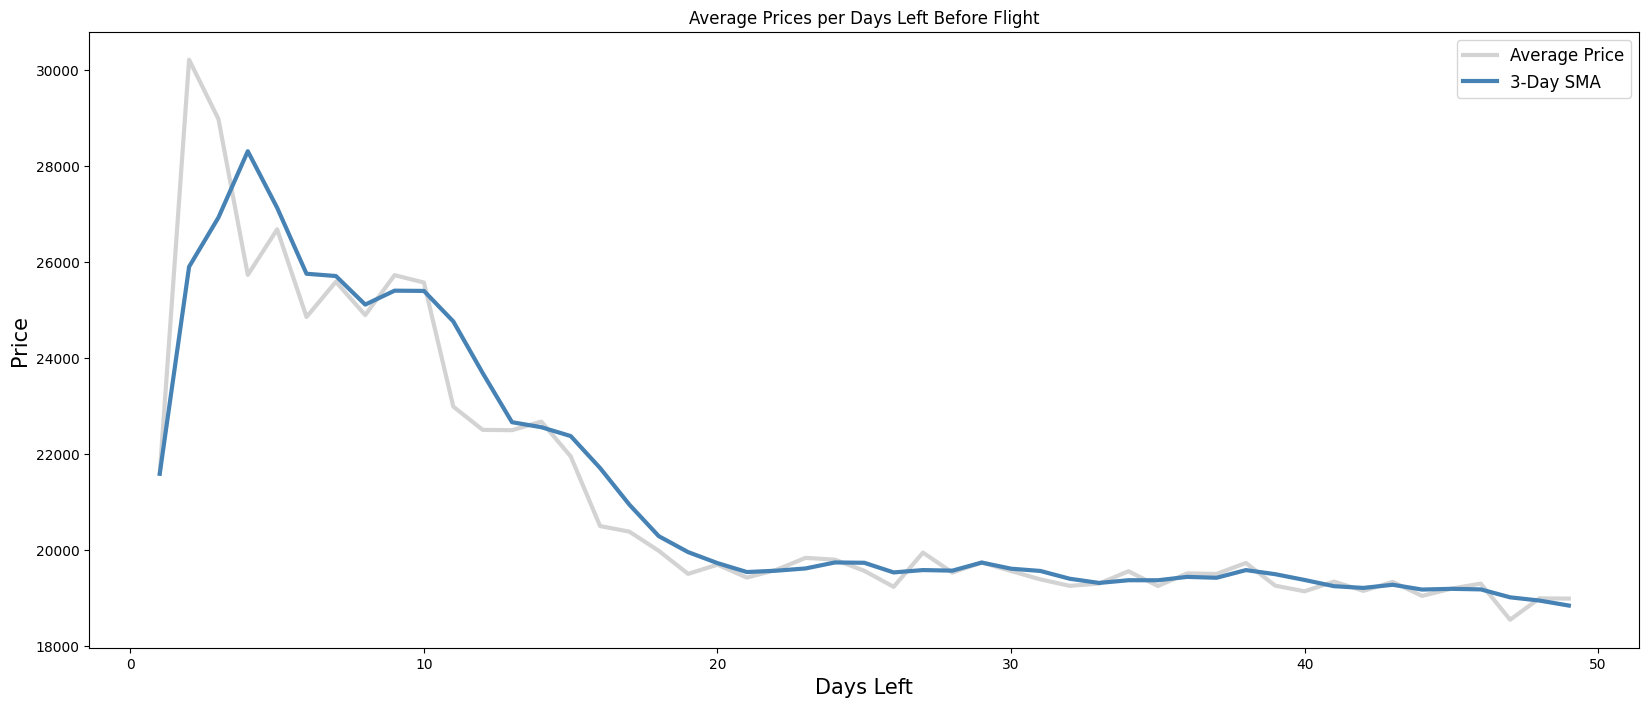

In [9]:
# 3-Day SMA Plot
colors = ['lightgray', 'steelblue']
df_avg.plot(x='days_left', y=['price', 'SMA_3'], color=colors, linewidth=3, figsize=(20,8))
plt.legend(labels=['Average Price', '3-Day SMA'], fontsize=12)
plt.title('Average Prices per Days Left Before Flight')
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

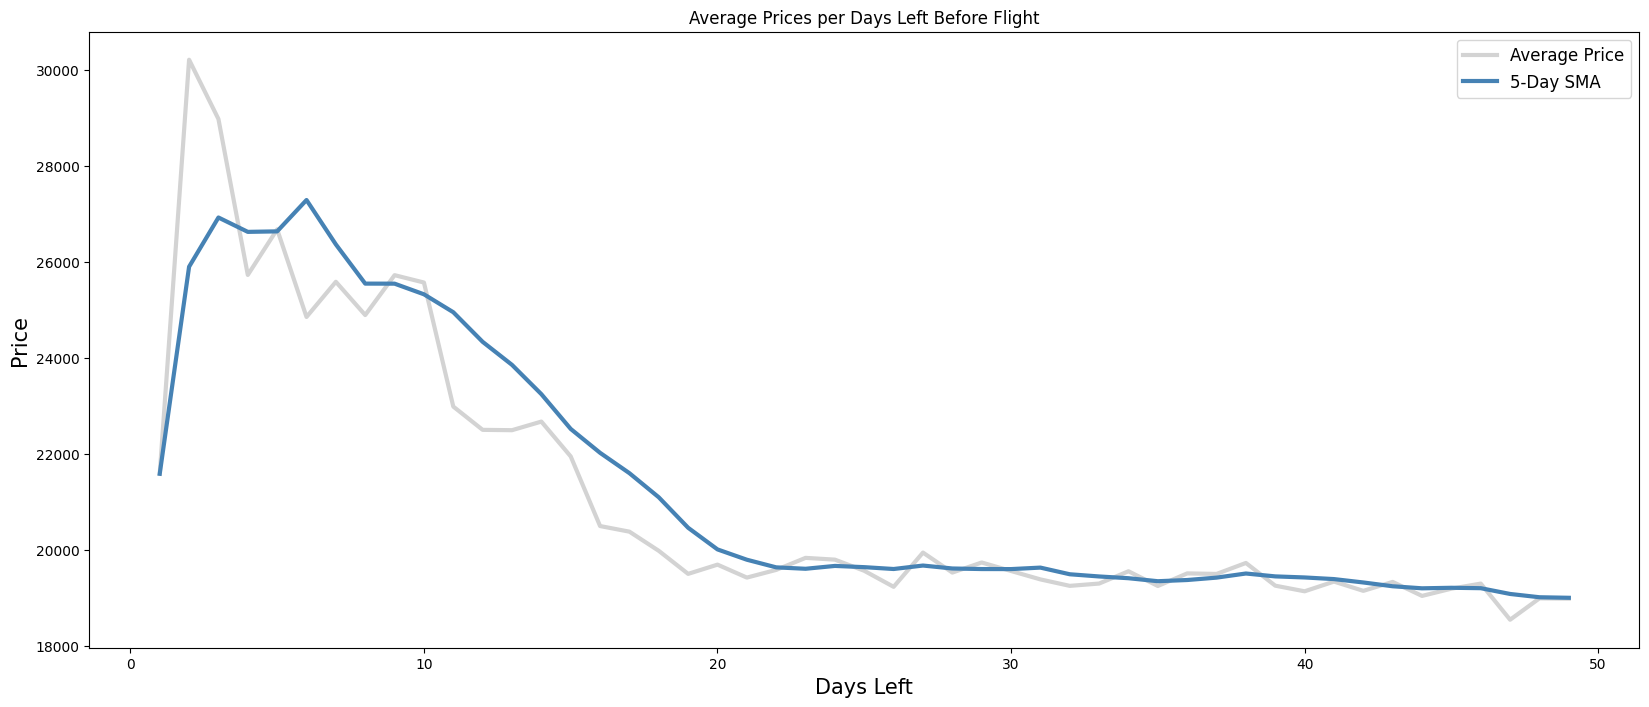

In [10]:
# 5-Day SMA Plot
colors = ['lightgray', 'steelblue']
df_avg.plot(x='days_left', y=['price', 'SMA_5'], color=colors, linewidth=3, figsize=(20,8))
plt.legend(labels=['Average Price', '5-Day SMA'], fontsize=12)
plt.title('Average Prices per Days Left Before Flight')
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

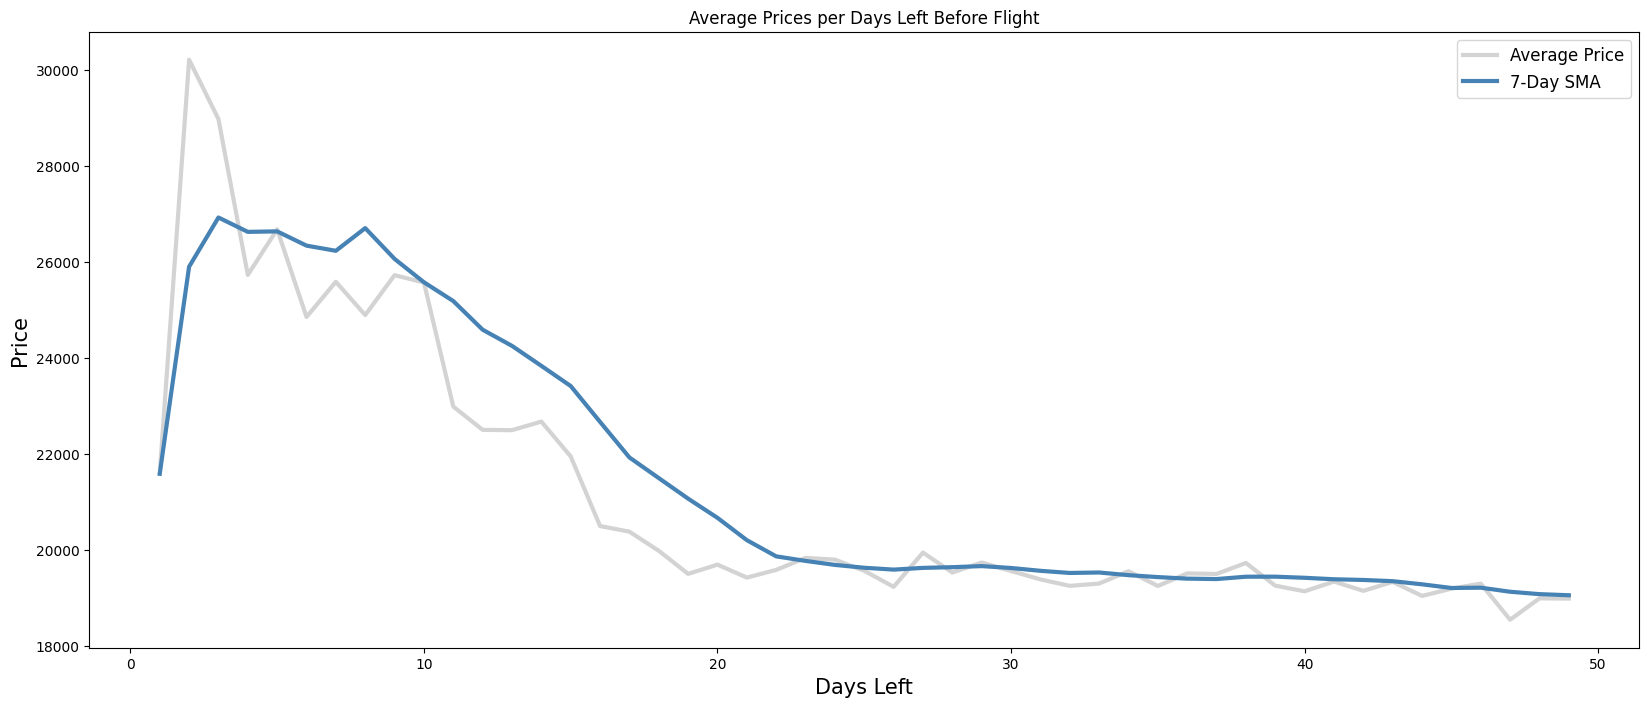

In [11]:
# 7-Day SMA Plot
colors = ['lightgray', 'steelblue']
df_avg.plot(x='days_left', y=['price', 'SMA_7'], color=colors, linewidth=3, figsize=(20,8))
plt.legend(labels=['Average Price', '7-Day SMA'], fontsize=12)
plt.title('Average Prices per Days Left Before Flight')
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

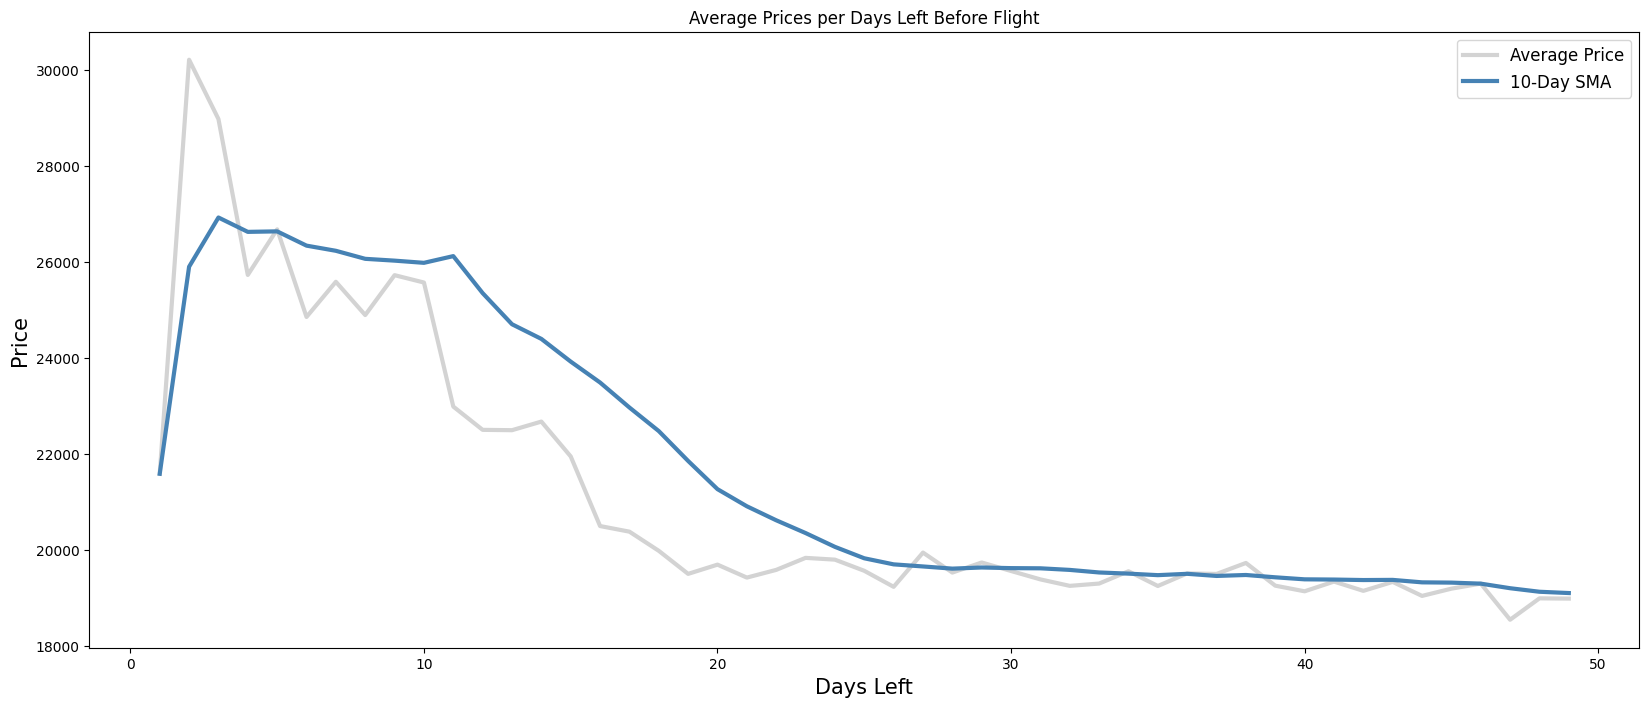

In [12]:
# 10-Day SMA Plot
colors = ['lightgray', 'steelblue']
df_avg.plot(x='days_left', y=['price', 'SMA_10'], color=colors, linewidth=3, figsize=(20,8))
plt.legend(labels=['Average Price', '10-Day SMA'], fontsize=12)
plt.title('Average Prices per Days Left Before Flight')
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

In [53]:
#### Method 2: Exponential Smoothing ####

# make another copy of data with average prices
df_es = df.groupby('days_left', as_index=False)['price'].mean()

# subset data for training
# we want to try to forecast days 45-49
train_es = df_es[df_es['days_left'] < 45]

# prep data
train_es = pd.Series(train_es['price'], train_es['days_left'])

In [76]:
# index for time series
# doesn't work

df_es = df.groupby('days_left', as_index=False)['price'].mean()
train_es = df_es[:45]

index = pd.date_range(start='2001', end='2044', freq='A')
train_es = pd.Series(train_es['price'], index)

In [77]:
# Simple Exponential Smoothing models

# alpha = 0.2
es_02 = SimpleExpSmoothing(train_es, initialization_method="heuristic").fit(smoothing_level=0.2, optimized=False)
fcast_02 = es_02.forecast(steps=5).rename("alpha = 0.2")

# alpha = 0.6
es_06 = SimpleExpSmoothing(train_es, initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
fcast_06 = es_06.forecast(steps=5).rename("alpha = 0.6")

# alpha = 0.9
es_09 = SimpleExpSmoothing(train_es, initialization_method="heuristic").fit(smoothing_level=0.9, optimized=False)
fcast_09 = es_09.forecast(steps=5).rename("alpha = 0.9")

# optimal alpha
es_opt = SimpleExpSmoothing(train_es, initialization_method="estimated").fit(optimized=True)
fcast_opt = es_opt.forecast(steps=5).rename("alpha = " % es_opt.model.params["smoothing_level"])

/Users/karynreal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


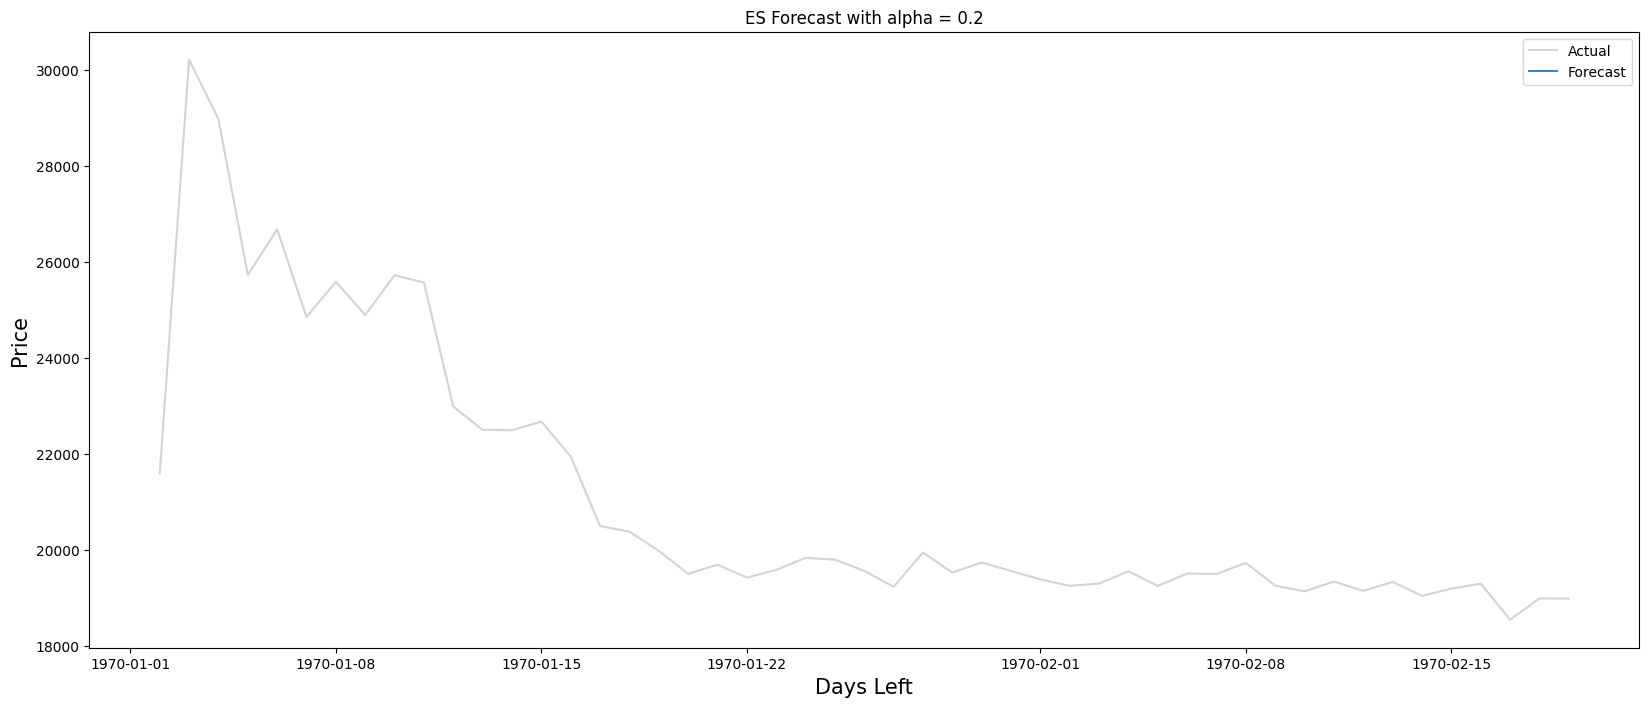

In [78]:
# alpha = 0.2 plot
df_es.plot(x = 'days_left', y = 'price', color="lightgray", figsize=(20,8))
plt.plot(es_02.fittedvalues, color="steelblue")
plt.plot(fcast_02, color="steelblue")
plt.legend(labels=["Actual", "Forecast"])
plt.title("ES Forecast with alpha = 0.2")
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

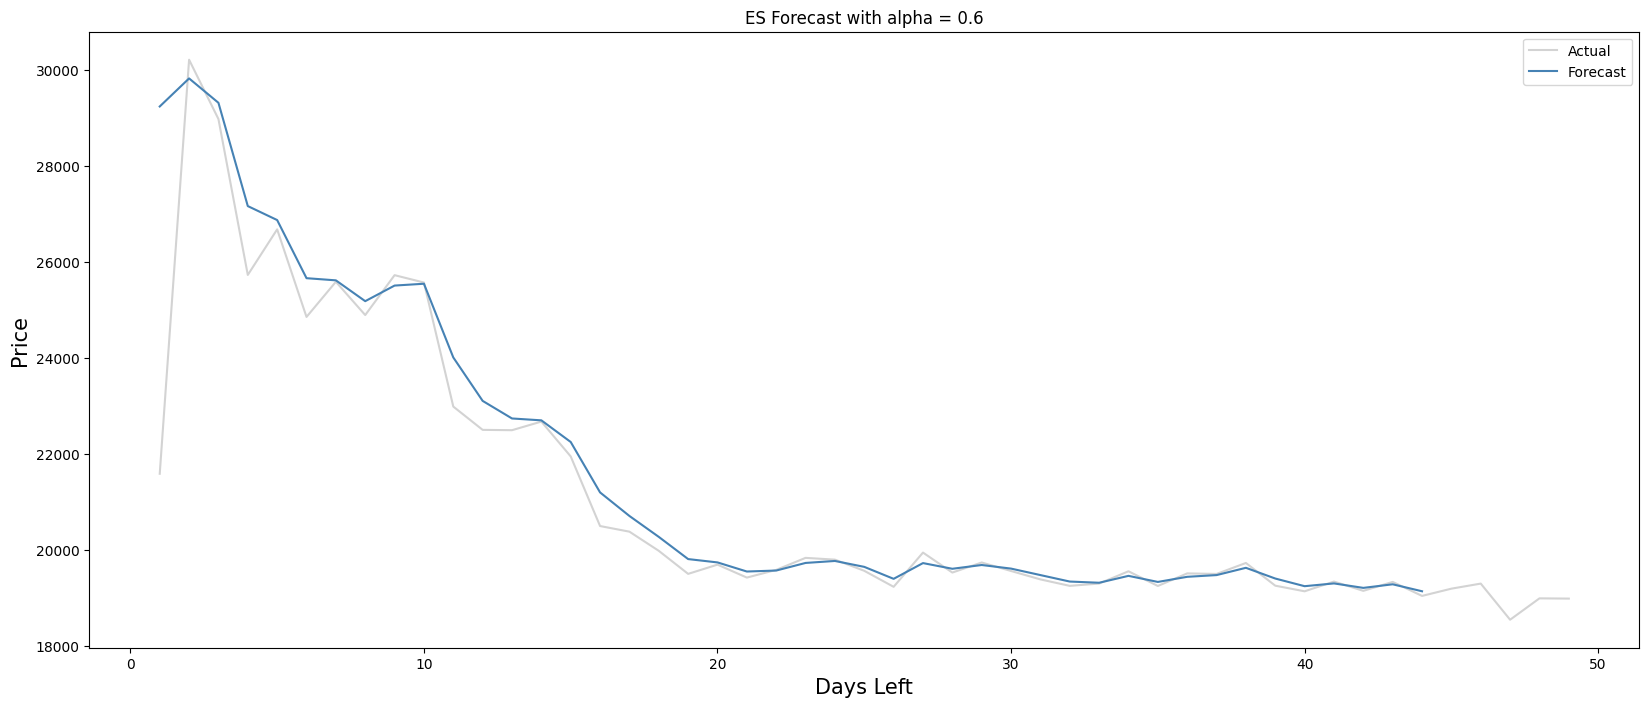

In [56]:
# alpha = 0.6 plot
df_es.plot(x = 'days_left', y = 'price', color="lightgray", figsize=(20,8))
plt.plot(es_06.fittedvalues, color="steelblue")
plt.plot(fcast_06, color="steelblue")
plt.legend(labels=["Actual", "Forecast"])
plt.title("ES Forecast with alpha = 0.6")
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

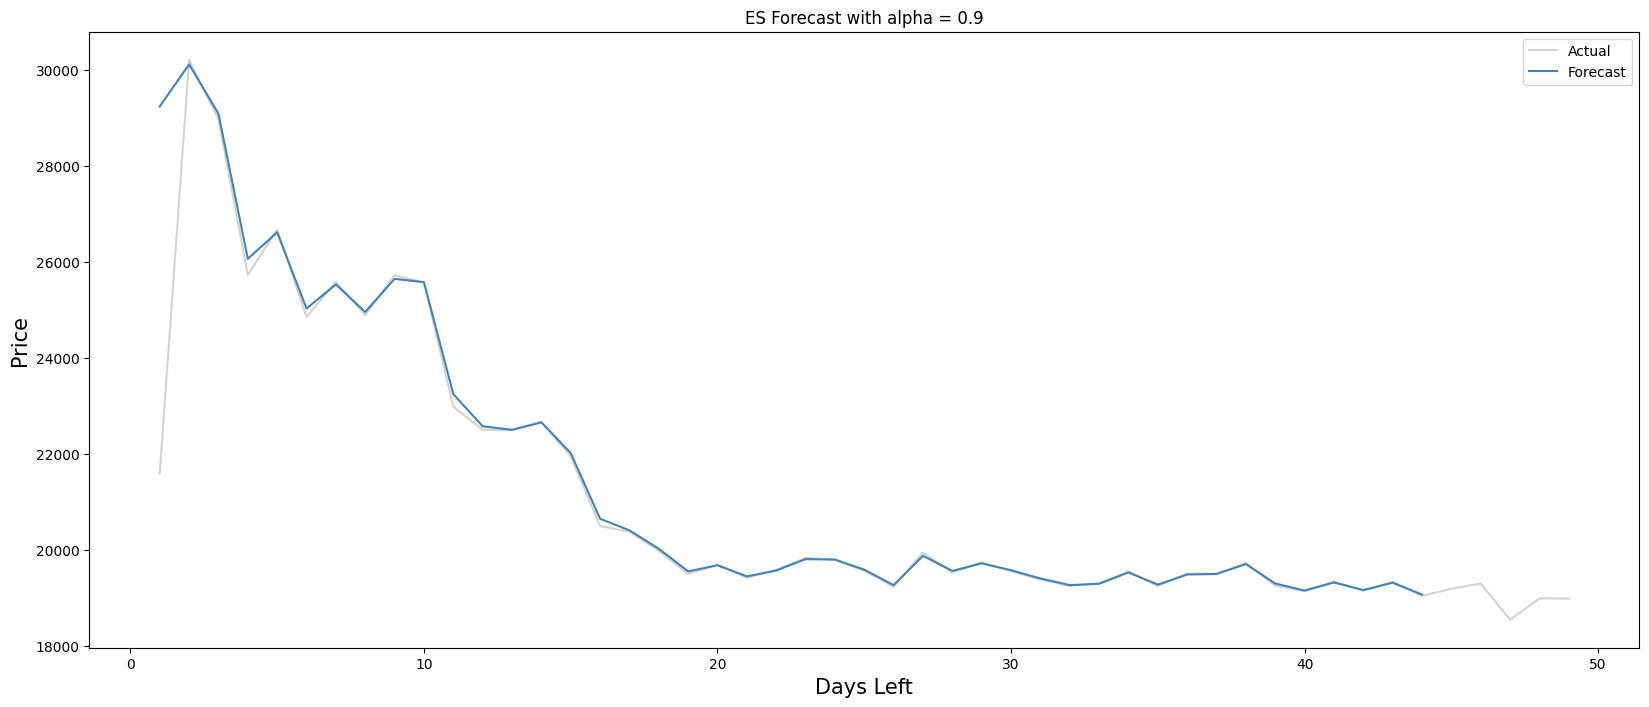

In [57]:
# alpha = 0.9 plot
df_es.plot(x = 'days_left', y = 'price', color="lightgray", figsize=(20,8))
plt.plot(es_09.fittedvalues, color="steelblue")
plt.plot(fcast_09, color="steelblue")
plt.legend(labels=["Actual", "Forecast"])
plt.title("ES Forecast with alpha = 0.9")
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

In [ ]:
# alpha = optimal plot
df_es.plot(x = 'days_left', y = 'price', color="lightgray", figsize=(20,8))
plt.plot(es_opt.fittedvalues, color="steelblue")
plt.plot(fcast_opt, color="steelblue")
plt.legend(labels=["Actual", "Forecast"])
plt.title("ES Forecast with " % fcast_opt.name)
plt.xlabel('Days Left', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

In [102]:
#### Method 3: Autoregressive model ####

# prep data
df_ar = df.groupby('days_left', as_index=False)['price'].mean()
prices = df_ar['price']
index = pd.period_range(start="2001", periods=49, freq='A')
prices.index = index
df_ar_endog = pd.Series(prices, index)
print(df_ar_endog.index)

PeriodIndex(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
             '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
             '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
             '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032',
             '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040',
             '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048',
             '2049'],
            dtype='period[A-DEC]')


In [100]:
# determine optimal value for p
mod = ar_select_order(prices, maxlag=13)
mod.ar_lags

[1]

In [115]:
ar_mod = ARIMA(prices, order=(1, 1, 0)).fit()
print(ar_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   49
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -407.430
Date:                Wed, 30 Nov 2022   AIC                            818.861
Time:                        17:39:59   BIC                            822.603
Sample:                    12-31-2001   HQIC                           820.275
                         - 12-31-2049                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3723      0.025     14.806      0.000       0.323       0.422
sigma2      1.601e+06   1.72e+05      9.305      0.000    1.26e+06    1.94e+06
Ljung-Box (L1) (Q):                   6.47   Jarque-

In [107]:
sm.stats.durbin_watson(ar_mod.resid.values)

1.9851797252922994

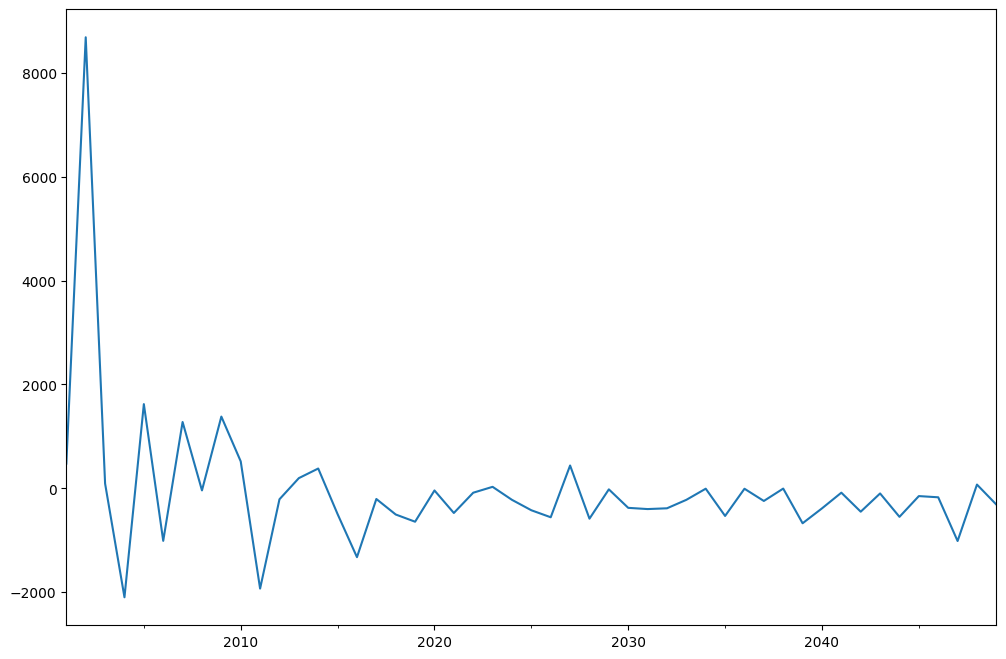

In [108]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = ar_mod.resid.plot(ax=ax)

In [109]:
resid = arma_mod10.resid
stats.normaltest(resid)

NormaltestResult(statistic=85.35781813787638, pvalue=2.9159850812055637e-19)

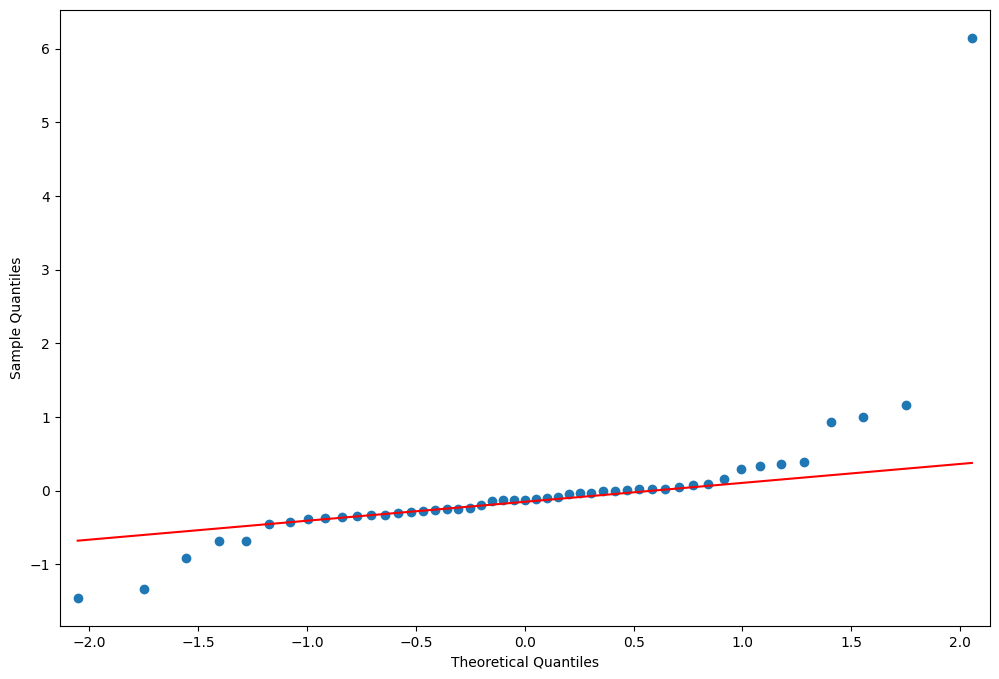

In [110]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)